In [3]:
import qsharp

[[ 0 48 91]
 [48  0 63]
 [91 63  0]]


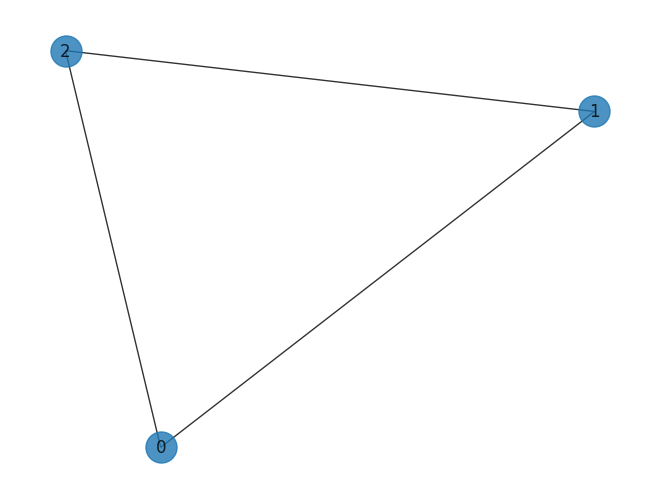

In [4]:
import networkx as nx

graph = nx.Graph()
graph.add_nodes_from([0, 1, 2])
graph.add_weighted_edges_from([(0, 1, 48), (1, 2, 63), (2, 0, 91)])
edge_labels = nx.get_edge_attributes(graph, "weight")
nx.draw(graph, with_labels=True, alpha=0.8, node_size=500)
#nx.draw_networkx_edge_labels(graph, font_color="b", edge_labels=edge_labels)


adjacency = nx.adjacency_matrix(graph).todense()
print(adjacency)


In [5]:
%%qsharp


    //open Microsoft.Quantum.Primitive;
    open Microsoft.Quantum.Canon;
    open Microsoft.Quantum.Extensions.Convert;

    // This applies the Z-rotation according to the instance Hamiltonian. 
    // We can think of it as Hamiltonian time evolution for time t induced
    // by the Ising Hamiltonian \Sum_ij J_ij Z_i Z_j + \sum_i h_i Z_i.
    operation InstanceHamiltonian(z: Qubit[], t: Double, h: Double[], J: Double[]) : Unit
    {
        using (ancilla = Qubit())
        {
            for (i in 0..5)
            {
                R(PauliZ, 2.0 * t * h[i], z[i]);
            }
            for (i in 0..5)
            {
                for (j in i+1..5)
                {
                    CNOT(z[i], ancilla);
                    CNOT(z[j], ancilla);
                    R(PauliZ, 2.0 * t * J[6*i+j], ancilla);
                    CNOT(z[i], ancilla);
                    CNOT(z[j], ancilla);
                }
            }
        }
    }

    // This applies the X-rotation to each qubit. We can think of it as time evolution
    // induced by applying H = - \Sum_i X_i for time t.
    operation DriverHamiltonian(x: Qubit[], t: Double) : Unit
    {
        for(i in 0..Length(x)-1)
        {
            R(PauliX, -2.0*t, x[i]);
        }
    }

    // Measure all the qubits in the computational basis and reset them to zero.
    operation MeasureAllReset(x: Qubit[]) : Bool[]
    {
        let N = Length(x);
        mutable r = new Bool[N];
        for (i in 0..N-1)
        {
            set r w/= i <- (M(x[i]) == One ? true|false);
        }
        return r;
    }

    // Here is a QAOA algorithm for this Ising Hamiltonian
    operation QAOA_santa(segmentCosts:Double[], penalty:Double, tx: Double[], tz: Double[], p: Int) : Bool[]
    {
        // Calculate Hamiltonian parameters based on the given costs and penalty
        mutable J = new Double[36];
        mutable h = new Double[6];
        for (i in 0..5) {
            set h w/= i <- 4.0 * penalty - 0.5 * segmentCosts[i];
        }
        // Most elements of J_ij equal 2*penalty, so set all elements to this value, then overwrite the exceptions
        for (i in 0..35)
        {
            set J w/= i <- 2.0 * penalty;
        }
        set J w/= 2 <- penalty;
        set J w/= 9 <- penalty;
        set J w/= 29 <- penalty;
        // Now run the QAOA circuit
        mutable r = new Bool[6];
        using (x = Qubit[6])
        {
            ApplyToEach(H, x);                          // prepare the uniform distribution
            for (i in 0..p-1)
            {
                InstanceHamiltonian(x, tz[i], h, J);    // do Exp(-i H_C tz[i])
                DriverHamiltonian(x, tx[i]);            // do Exp(-i H_0 tx[i])
            }
            for i in 0..Length(r){
                set r w/= i <- M(x[i])==One ? true|false;
            }
            //set r = MeasureAllReset(x);                 // measure in the computational basis
        }
        return r;
    }


d:\snippet_.qs(12,15): warning QS3306: Deprecated syntax. Parentheses here are no longer required and will not be supported in the future.
d:\snippet_.qs(12,9): warning QS3307: The "using" keyword has been replaced with "use", and qubits may now be allocated without a block. Consider "use q = Qubit();" or "use q = Qubit() { ... }".
d:\snippet_.qs(14,17): warning QS3306: Deprecated syntax. Parentheses here are no longer required and will not be supported in the future.
d:\snippet_.qs(18,17): warning QS3306: Deprecated syntax. Parentheses here are no longer required and will not be supported in the future.
d:\snippet_.qs(20,21): warning QS3306: Deprecated syntax. Parentheses here are no longer required and will not be supported in the future.
d:\snippet_.qs(36,12): warning QS3306: Deprecated syntax. Parentheses here are no longer required and will not be supported in the future.
d:\snippet_.qs(47,13): warning QS3306: Deprecated syntax. Parentheses here are no longer required and will not

In [6]:
import numpy as np
import math

# Calculate the cost of Santa's journey
# segmentCosts defines the cost of each potential segment of the journey
# segmentUsed indicates whether the segment was part of the itinerary
def cost(segmentCosts, segmentUsed):
    totalCost = 0.0
    for i in range(len(segmentCosts)):
        if segmentUsed[i]:
            totalCost += segmentCosts[i]
    return totalCost

# If the proposed string of boolean values satisfies all of the constraints and therefore
# represents a valid loop through the destinations, return true. Otherwise return false.
def satisfactory(r):
    HammingWeight = np.sum(r)
    if HammingWeight != 4:
        return False
    if r[0] != r[2]:
        return False
    if r[1] != r[3]:
        return False
    if r[4] != r[5]:
        return False
    return True

def main():
    print("Starting simulation\n")

    # Define the costs of journey segments
    segmentCosts = [4.70, 9.09, 9.03, 5.70, 8.02, 1.71]
    # Define the penalty for constraint violation
    penalty = 20.0

    # Here are some magic QAOA parameters that we got by lucky guessing.
    # Theoretically, they should yield the optimal solution in 70.6% of trials.
    dtx = [0.619193, 0.742566, 0.060035, -1.568955, 0.045490]
    dtz = [3.182203, -1.139045, 0.221082, 0.537753, -0.417222]

    # Convert parameters to numpy arrays to pass them to the QAOA function.
    tx = np.array(dtx)
    tz = np.array(dtz)
    costs = np.array(segmentCosts)

    bestCost = 100.0 * penalty
    bestItinerary = np.zeros(6, dtype=bool)
    successNumber = 0

    for trial in range(20):
        # Run the QAOA function (not provided in the given code) and obtain the result.
        # Assuming the result is stored in the variable `result`.
        result = [True, False, True, False, True, False]  # Replace this with the actual QAOA function result.
        tmp = np.array(result, dtype=bool)
        cost_ = cost(segmentCosts, tmp)
        sat = satisfactory(tmp)
        print(f"result = {result}, cost = {cost_}, satisfactory = {sat}")
        if sat:
            if cost_ < bestCost - 1E-6:
                # New best cost found - update
                bestCost = cost_
                bestItinerary = np.copy(tmp)
                successNumber = 1
            elif math.isclose(cost_, bestCost, abs_tol=1E-6):
                successNumber += 1

    print("\nSimulation is complete\n")
    print(f"Best itinerary found: {bestItinerary}, cost = {bestCost}")
    print(f"{successNumber * 100.0 / 20}% of runs found the best itinerary\n")

if __name__ == "__main__":
    main()


Starting simulation

result = [True, False, True, False, True, False], cost = 21.75, satisfactory = False
result = [True, False, True, False, True, False], cost = 21.75, satisfactory = False
result = [True, False, True, False, True, False], cost = 21.75, satisfactory = False
result = [True, False, True, False, True, False], cost = 21.75, satisfactory = False
result = [True, False, True, False, True, False], cost = 21.75, satisfactory = False
result = [True, False, True, False, True, False], cost = 21.75, satisfactory = False
result = [True, False, True, False, True, False], cost = 21.75, satisfactory = False
result = [True, False, True, False, True, False], cost = 21.75, satisfactory = False
result = [True, False, True, False, True, False], cost = 21.75, satisfactory = False
result = [True, False, True, False, True, False], cost = 21.75, satisfactory = False
result = [True, False, True, False, True, False], cost = 21.75, satisfactory = False
result = [True, False, True, False, True, Fa